This notebook is for generating error distribution as well as track plots

## Loading Data and Model

In [22]:
import importlib
import yaml
from yaml.loader import SafeLoader
from smoother.data import zod_data

def load_config(config_path:str):
    with open(config_path) as f:
        conf = yaml.load(f, Loader=SafeLoader)
    return conf

conf_path = '/AutoAnnSmoother/configs/training_config.yaml'
conf = load_config(conf_path)

version = 'full'
split = "train"
result_path = "/results.json"
data_path = "/datasets/zod/zodv2"

tracking_results = zod_data.ZodTrackingResults(result_path,conf,version,split, data_path=data_path)

Initializing ZodData class...


Loading train sequences:   0%|          | 0/1165 [00:00<?, ?it/s]

Loading val sequences:   0%|          | 0/294 [00:00<?, ?it/s]

Loading prediction and ground-truths ...


100%|██████████| 1165/1165 [02:54<00:00,  6.68it/s]


In [23]:
from smoother.data.common import tracking_data

window_size = 9

seqs = None#['000589','000557','000671','000719','001223',"000288", "000566"]
track_data = tracking_data.WindowTrackingData(
            tracking_results=tracking_results,
            window_size=window_size,
            times=1,
            random_slides=False,
            use_pc=True,
            transformations=[],
            points_transformations=[],
            remove_non_foi_tracks=True,
            remove_non_gt_tracks=False,
            seqs=seqs,
        )

Loading sequences...


100%|██████████| 1165/1165 [04:57<00:00,  3.91it/s]

Finished loading 20864 data samples!


In [3]:
import importlib
import yaml
from yaml.loader import SafeLoader

from smoother.data import zod_data
importlib.reload(zod_data)
from smoother.data import zod_data


def load_config(config_path:str):
    with open(config_path) as f:
        conf = yaml.load(f, Loader=SafeLoader)
    return conf

conf_path = '/AutoAnnSmoother/configs/training_config.yaml'
conf = load_config(conf_path)

version = 'full'
split = "train"
result_path = "/staging/agp/masterthesis/2023autoann/storage/smoothing/autoannsmoothing/results_albin/vehicle-w15-iou04-rnd-pctracknetef-transformer-e100_train_world.json"
data_path = "/datasets/zod/zodv2"

smoothing_results = zod_data.ZodTrackingResults(result_path,conf,version,split, data_path=data_path)

Initializing ZodData class...


Loading train sequences:   0%|          | 0/1165 [00:00<?, ?it/s]

Loading val sequences:   0%|          | 0/294 [00:00<?, ?it/s]

Loading prediction and ground-truths ...


100%|██████████| 1165/1165 [02:03<00:00,  9.42it/s]


In [4]:
import importlib
from smoother.data.common import tracking_data
importlib.reload(tracking_data)
from smoother.data.common import tracking_data

import importlib
from smoother.data.common import transformations as t
importlib.reload(t)
from smoother.data.common import transformations as t

from smoother.data.common import dataclasses
importlib.reload(dataclasses)
from smoother.data.common import dataclasses

window_size = 9

seqs = ['000589','000557','000671','000719','001223',"000288", "000566"]
smoothing_data = tracking_data.WindowTrackingData(
            tracking_results=smoothing_results,
            window_size=window_size,
            times=1,
            random_slides=False,
            use_pc=True,
            transformations=[],
            points_transformations=[],
            remove_non_foi_tracks=True,
            remove_non_gt_tracks=False,
            seqs=seqs,
        )

Loading sequences...


100%|██████████| 7/7 [00:01<00:00,  6.05it/s]

Finished loading 223 data samples!


## IoU Association Histogram

In [20]:

n_gt = 0
gts = {}
ds = []
for i in range(len(track_data)):
    tracklet = track_data.get(i)
    if tracklet.has_gt:
        n_gt += 1
        gt_box = tracklet.gt_box
        id = gt_box["instance_token"]
        ds.append(tracklet.gt_dist)
print(n_gt)
print(len(track_data))

994
3027


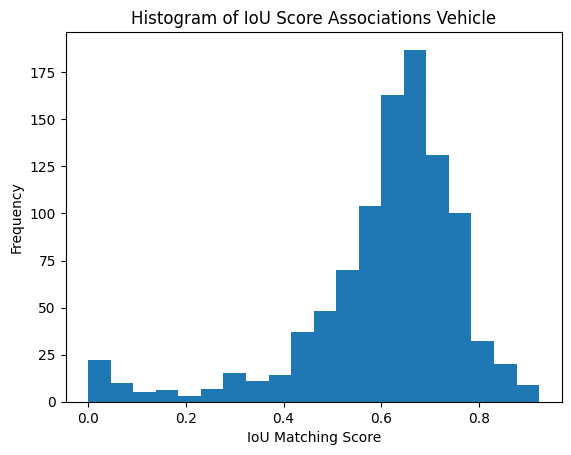

In [21]:
from matplotlib import pyplot as plt

plt.hist(ds, bins=20)
plt.ylabel("Frequency")
plt.xlabel("IoU Matching Score")
plt.title("Histogram of IoU Score Associations Vehicle")
plt.savefig("ped-iou-score.pdf", format="pdf")
plt.show()

## Track Visualisation

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrow

def draw_box(ax, x, y, length, width, rotation_yaw, edgecolor, linestyle, linewidth, alpha=1):
    dx1, dy1 = length / 2 * np.cos(rotation_yaw), length / 2 * np.sin(rotation_yaw)
    dx2, dy2 = width / 2 * np.sin(rotation_yaw), -width / 2 * np.cos(rotation_yaw)
    corner1 = (x - dx1 + dx2, y - dy1 + dy2)
    corner2 = (x + dx1 + dx2, y + dy1 + dy2)
    corner3 = (x + dx1 - dx2, y + dy1 - dy2)
    corner4 = (x - dx1 - dx2, y - dy1 - dy2)

    # Create the bounding box
    rect = Rectangle(
        corner1,
        length,
        width,
        angle=np.degrees(rotation_yaw),
        edgecolor=edgecolor,
        linestyle=linestyle,
        linewidth=linewidth,
        fill=False,
        alpha=alpha,
    )
    ax.add_patch(rect)

def draw_arrow(ax, x, y, length, width, rotation_yaw, color, linestyle, linewidth):
    arrow_length = 1
    arrow_dx = arrow_length * np.cos(rotation_yaw)
    arrow_dy = arrow_length * np.sin(rotation_yaw)
    arrow = FancyArrow(
        x,
        y,
        arrow_dx,
        arrow_dy,
        color=color,
        head_length=min(width, length) / 4,
        head_width=min(width, length) / 4,
        alpha=0.8,
        linestyle=linestyle,
        linewidth=linewidth,
    )
    ax.add_patch(arrow)

def visualize_tracklet(tracklet, gt=None, points=None, foi_ind=None, gt_dist=0, save=False):
    fig, ax = plt.subplots()

    min_x, max_x, min_y, max_y = float('inf'), float('-inf'), float('inf'), float('-inf')
    
    # Visualize tracklet
    for i, box in enumerate(tracklet):
        if i == foi_ind:
            color = "black"
            linestyle = "-"
            linewidth = 1
            alpha = 1
        else:
            color = "grey"
            linestyle = "--"
            linewidth = 0.5
            alpha = 0.5

        x, y, z, length, width, height, rotation_yaw, _ = box
        draw_box(ax, x, y, length, width, rotation_yaw, color, linestyle, linewidth, alpha)
        draw_arrow(ax, x, y, length, width, rotation_yaw, color, linestyle, linewidth)

        min_x = min(min_x, x - length / 2, x + length / 2)
        max_x = max(max_x, x - length / 2, x + length / 2)
        min_y = min(min_y, y - width / 2, y + width / 2)
        max_y = max(max_y, y - width / 2, y + width / 2)
        
    # Visualize ground-truth
    if gt is not None:
        gt_x, gt_y, gt_z, gt_length, gt_width, gt_height, gt_rotation_yaw = gt[:7]
        draw_box(ax, gt_x, gt_y, gt_length, gt_width, gt_rotation_yaw, "green", "--", 2)
        draw_arrow(ax, gt_x, gt_y, gt_length, gt_width, gt_rotation_yaw, "green", "--", 2)

        min_x = min(min_x, gt_x - gt_length / 2, gt_x + gt_length / 2)
        max_x = max(max_x, gt_x - gt_length / 2, gt_x + gt_length / 2)
        min_y = min(min_y, gt_y - gt_width / 2, gt_y + gt_width / 2)
        max_y = max(max_y, gt_y - gt_width / 2, gt_y + gt_width / 2)

    # Visualize Points
    if points is not None:
        xs = points[0, :, 0]
        ys = points[0, :, 1]
        ax.scatter(xs,ys)

    padding = 3.5
    ax.set_xlim(min_x - padding, max_x + padding)
    ax.set_ylim(min_y - padding, max_y + padding)
    ax.set_aspect('equal')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    #plt.title(f"Ped Tracklet with GIoU distance {gt_dist}")
    if save:
        plt.savefig(f"v-track-iou-dist-{gt_dist}.pdf", format="pdf")
    plt.show()


In [7]:
import torch
def _get_rotation_matrix(yaw):
    c, s = torch.cos(yaw), torch.sin(yaw)
    return torch.tensor([[c, -s, 0], [s, c, 0], [0, 0, 1]])

def transform(local_centers, center_offset, rotation_matrix):
    """
    local_centers (N,3)
    center (1,3)
    rotation_matrix (3,3)
    """

    trans = torch.cat((rotation_matrix, center_offset.transpose(1, 0)), dim=-1)
    trans = torch.cat(
        (trans, torch.tensor([[0, 0, 0, 1]], dtype=torch.float32)), dim=0
    )

    ones = torch.ones((local_centers.shape[0], 1), dtype=torch.float32)

    points_homogeneous = torch.cat((local_centers, ones), dim=-1)

    transformed_points = trans @ points_homogeneous.T

    # Remove the homogeneous coordinate
    transformed_points = transformed_points[0:3].squeeze(-1)

    return transformed_points.T

In [5]:
import heapq

def find_extreme_gt_distances(track_data, top_n, find_largest=True, min_cap=None, max_cap=None):
    """
    Find the top_n smallest/largest gt distances in track_data.

    Args:
        track_data (list): The data to process.
        top_n (int): The number of top smallest/largest distances to find.
        find_largest (bool): If True, find the largest distances. If False, find the smallest.
        min_cap (float, optional): If set, ignore distances below this value.
        max_cap (float, optional): If set, ignore distances above this value.

    Returns:
        list: A list of tuples, where each tuple contains a gt distance and its index.
    """

    # Create a list to hold the top gt distances and their indices
    top_gt_distances = []

    for i in range(len(track_data)):
        tracklet = track_data.get(i)
        if not tracklet.has_gt:
            continue
        gt_dist = tracklet.gt_dist

        # Skip if the distance is below the min cap or above the max cap
        if (min_cap is not None and gt_dist < min_cap) or (max_cap is not None and gt_dist > max_cap):
            continue

        # Use a negative gt_dist for a max heap if find_largest is True
        if not find_largest:
            gt_dist = -gt_dist

        if len(top_gt_distances) < top_n:
            heapq.heappush(top_gt_distances, (gt_dist, i))
        elif gt_dist > top_gt_distances[0][0]:
            heapq.heappushpop(top_gt_distances, (gt_dist, i))

    # Convert back to original distances for output
    top_gt_distances = [(-dist if not find_largest else dist, idx) for dist, idx in top_gt_distances]

    # Heapify the list
    heapq.heapify(top_gt_distances)

    # Pop from the heap to get a sorted list
    sorted_top_gt_distances = []
    while top_gt_distances:
        sorted_top_gt_distances.append(heapq.heappop(top_gt_distances))

    return sorted_top_gt_distances

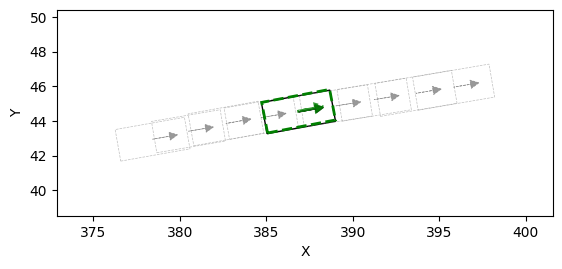

In [41]:
import numpy as np
import copy
import torch
i= 14891
'''
Vehicle: [(7741, 0.000), (11031, 0.001), (12486, 0.202), (17467, 0.400), (20428, 0.600), (1637, 0.800), (14891, 0.950) ]
Pedestrian: [(3013, 0.000), (1126, 0.001), (241, 0.228), (695, 0.257), (1893, 0.408), (2476, 0.418), (725, 0.601), (693, 0.603)]
VulnerableVehicle: [(485, 0.003), (236, 0.008), (321, 0.215), (348, 0.219), (330, 0.418), (125, 0.438), (501, 0.601),(373, 0.607)]
'''

track, point, gt = track_data[i]
tracklet = track_data.get(i)
rel_foi_ind = tracklet.foi_index - tracklet.starting_frame_index #track relative
window_start_ind = rel_foi_ind - window_size//2
start_ind = max(0,window_start_ind)
end_ind = start_ind + window_size
track_world = [box.center + box.size + box.rotation + [-1] for box in tracklet.boxes[start_ind:end_ind]]

gt_box = tracklet.gt_box
if gt_box:
    gt_world = gt_box["translation"] + gt_box["size"] + gt_box["rotation"]
else:
    gt_world = None
    gt = None
    print("No GT box found")

# Compute window_foi_index
window_foi_index = rel_foi_ind - start_ind
if window_foi_index < 0:
    window_foi_index = 0

gt_dist = round(tracklet.gt_dist.item(),3)
visualize_tracklet(track_world, gt_world, foi_ind=window_foi_index, gt_dist=gt_dist, save=True)


0.9500036514606733 1795


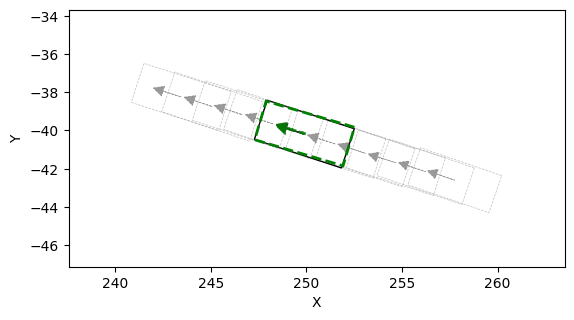

0.9500152370069188 14891


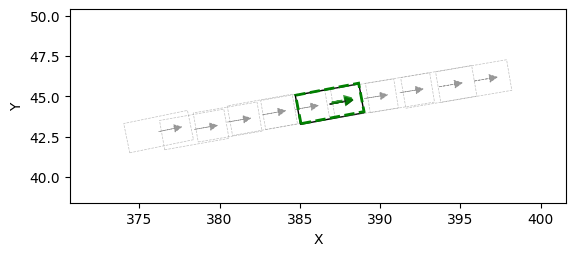

0.9500868220545649 6534


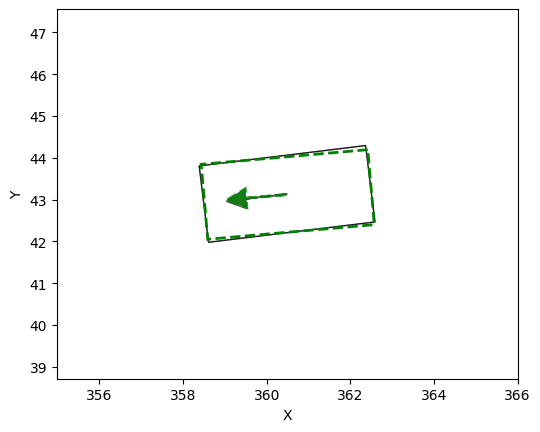

0.9500959066906888 962


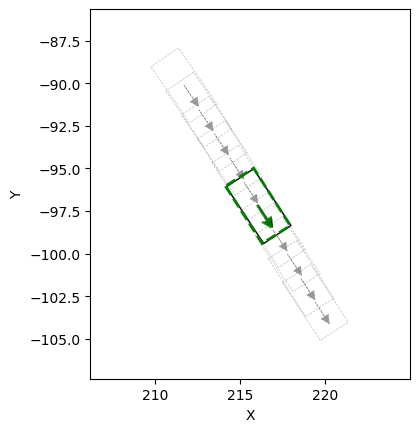

0.9500960067843948 16768


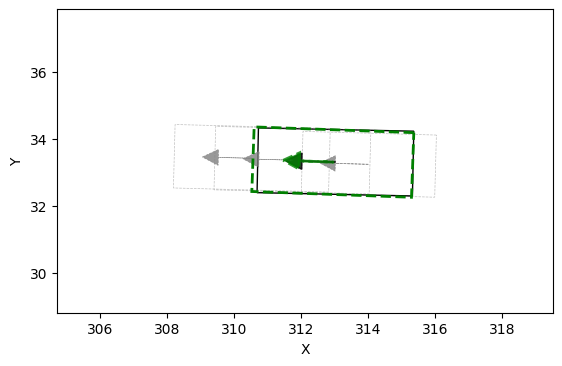

0.9501538049529928 15898


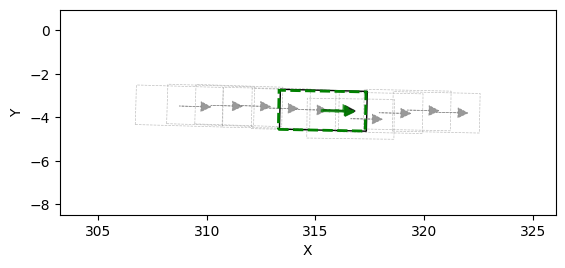

0.9501705792066685 2241


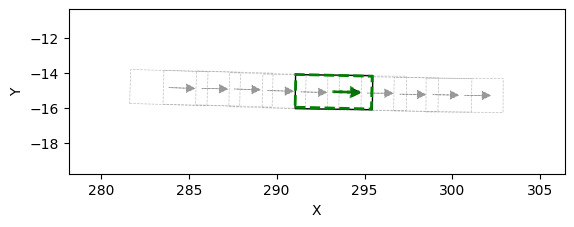

0.950190709636109 736


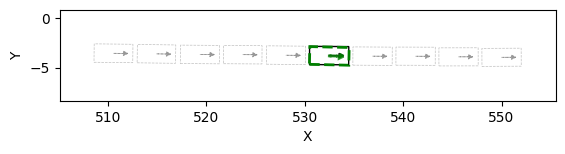

0.9502299750841503 9866


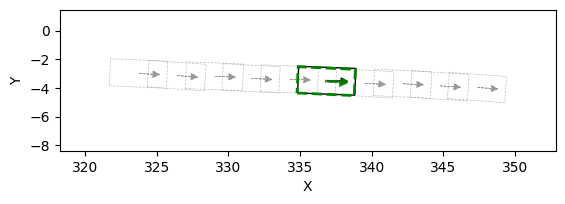

0.9502333697782009 14060


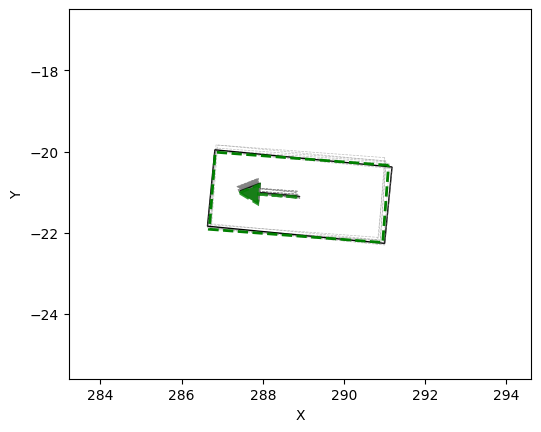

0.9502926502232188 16194


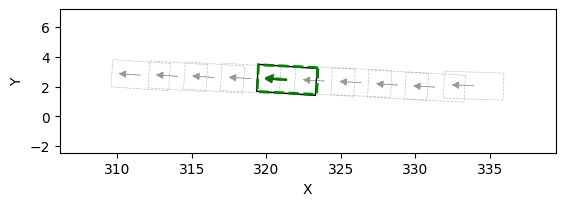

0.9502940366332656 16292


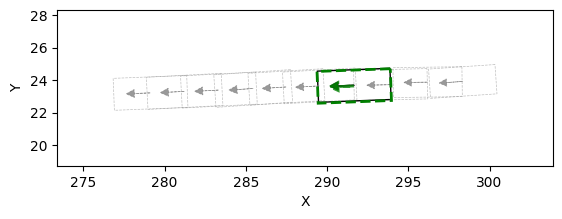

0.9503001580372195 4919


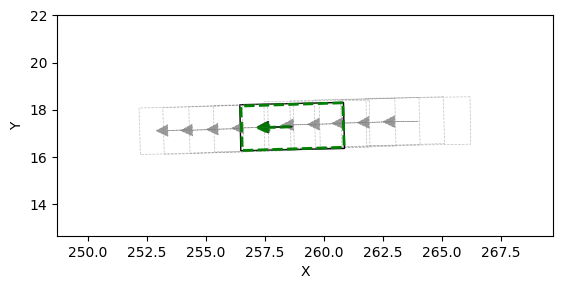

0.9503129831759598 1296


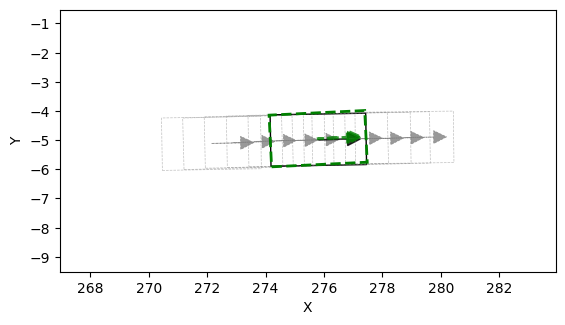

0.9503158094859294 106


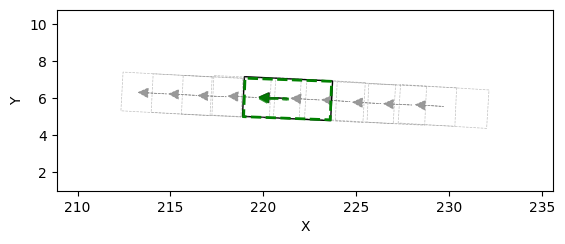

0.9503314840548013 10790


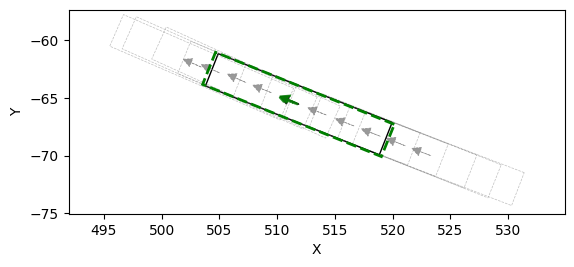

0.9503376968732143 14453


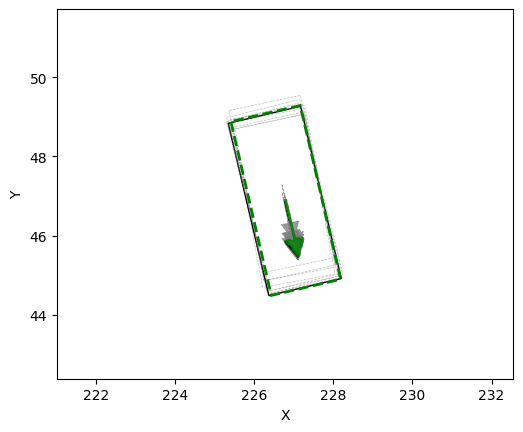

0.9503408602572531 5342


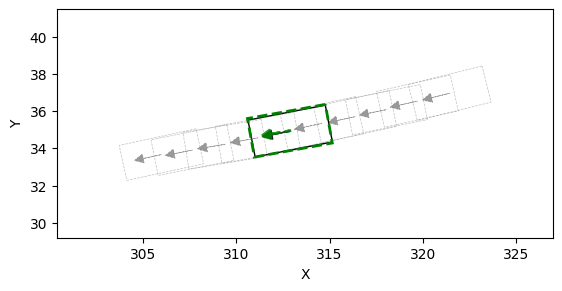

0.9504013521142398 4265


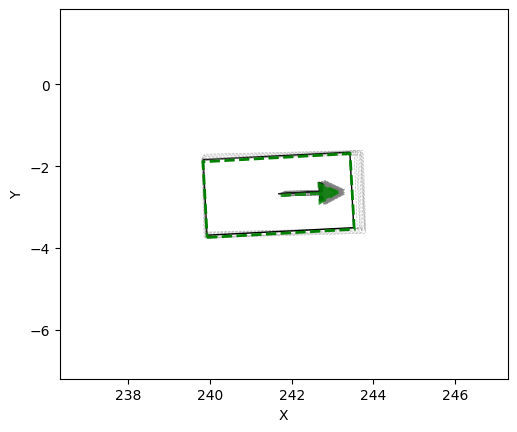

0.9504022241103599 3260


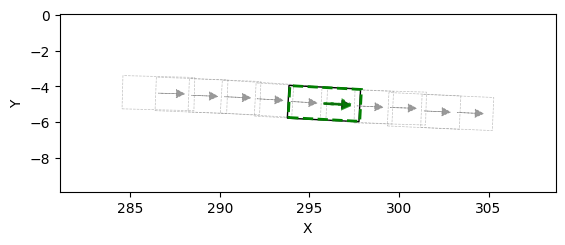

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_extreme_gt_distances(track_data, top_gt_distances, window_size):
    for gt_dist, i in top_gt_distances:
        print(gt_dist, i)
        tracklet = track_data.get(i)

        rel_foi_ind = tracklet.foi_index - tracklet.starting_frame_index
        window_start_ind = rel_foi_ind - window_size//2
        start_ind = max(0,window_start_ind)
        end_ind = start_ind + window_size
        track_world = [box.center + box.size + box.rotation + [-1] for box in tracklet.boxes[start_ind:end_ind]]

        gt_box = tracklet.gt_box
        if gt_box:
            gt_world = gt_box["translation"] + gt_box["size"] + gt_box["rotation"]
        else:
            gt_world = None
            print("No GT box found")

        # Compute window_foi_index
        window_foi_index = rel_foi_ind - start_ind
        if window_foi_index < 0:
            window_foi_index = 0
            
        visualize_tracklet(track_world, gt_world, foi_ind=window_foi_index, gt_dist=gt_dist)
        plt.show()


largest_gt_distances = find_extreme_gt_distances(track_data, 20, find_largest=False, min_cap=0.95)
visualize_extreme_gt_distances(track_data, largest_gt_distances, window_size=10)

## Error Histograms

100%|██████████| 3027/3027 [00:00<00:00, 53255.03it/s]


Total error: tensor([  64.3822,   58.7061,   70.2738,  110.3195,   73.1513,   88.5145,
        1597.6842])
Total gt-samples: 976
Mean error: tensor([0.0660, 0.0601, 0.0720, 0.1130, 0.0750, 0.0907, 1.6370])


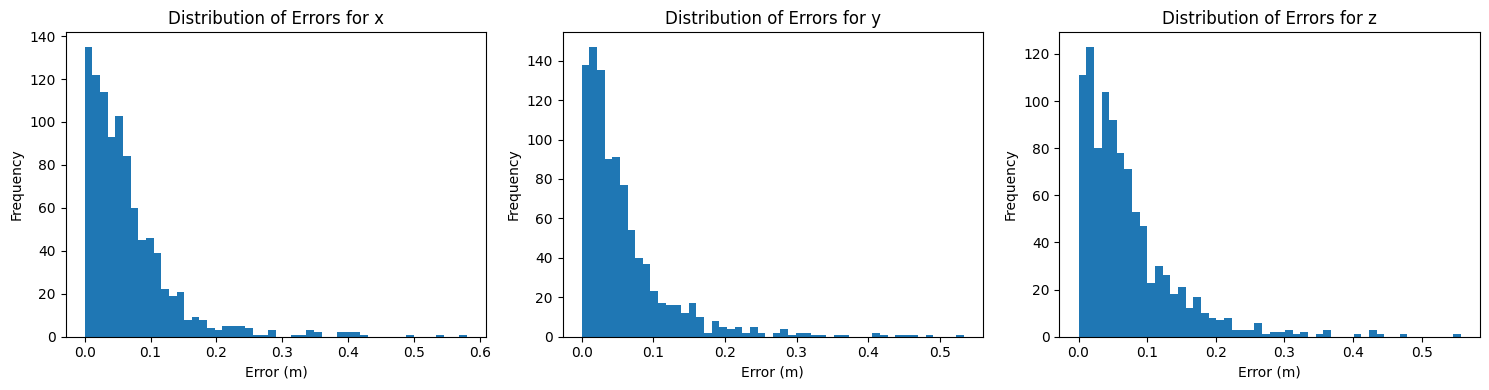

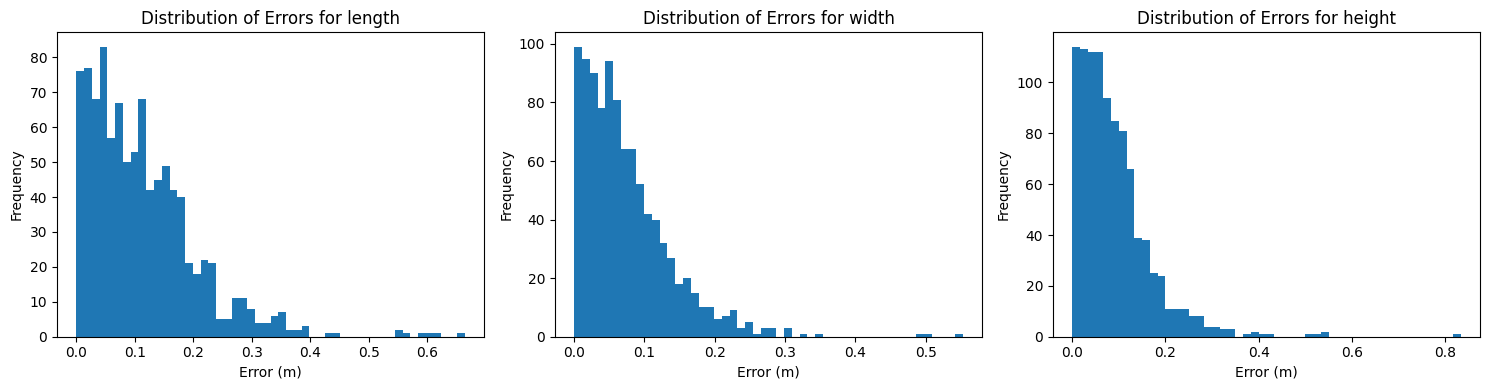

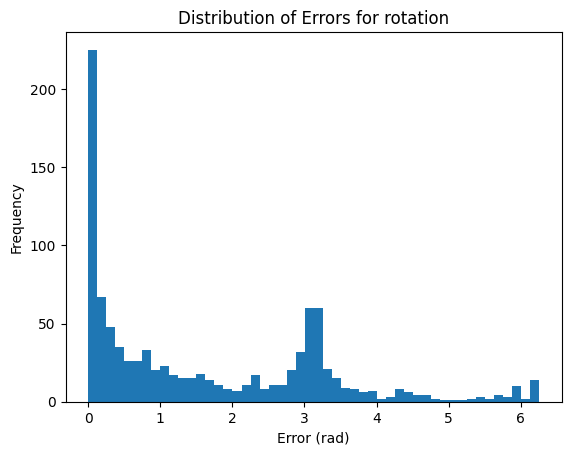

In [47]:
import tqdm
import torch
import matplotlib.pyplot as plt
import math

feat_err = torch.zeros(7)
n = 0
errors = []
track_lengths = []

for i in tqdm.tqdm(range(len(track_data))):
    tracklet = track_data.get(i)
    track_lengths.append(len(tracklet))
    if not tracklet.has_gt:
        continue

    foi_box = tracklet.get_foi_box()
    gt_box = tracklet.gt_box
    track = torch.tensor(foi_box.center + foi_box.size + foi_box.rotation)
    gt = torch.tensor(gt_box["translation"] + gt_box["size"] + gt_box["rotation"])

    e = abs(gt - track)

    feat_err += e

    n += 1
    errors.append(e)


mean_feat_error = feat_err / n
print("Total error:", feat_err)
print("Total gt-samples:", n)
print("Mean error:", mean_feat_error)

# Plotting x, y, z side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].hist([e[0].item() for e in errors], bins=50)
axs[0].set_title("Distribution of Errors for x")
axs[0].set_xlabel("Error (m)")
axs[0].set_ylabel("Frequency")

axs[1].hist([e[1].item() for e in errors], bins=50)
axs[1].set_title("Distribution of Errors for y")
axs[1].set_xlabel("Error (m)")
axs[1].set_ylabel("Frequency")

axs[2].hist([e[2].item() for e in errors], bins=50)
axs[2].set_title("Distribution of Errors for z")
axs[2].set_xlabel("Error (m)")
axs[2].set_ylabel("Frequency")

plt.tight_layout()
plt.savefig("center-error-hist.png")
plt.show()

# Plotting length, width, height side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].hist([e[3].item() for e in errors], bins=50)
axs[0].set_title("Distribution of Errors for length")
axs[0].set_xlabel("Error (m)")
axs[0].set_ylabel("Frequency")

axs[1].hist([e[4].item() for e in errors], bins=50)
axs[1].set_title("Distribution of Errors for width")
axs[1].set_xlabel("Error (m)")
axs[1].set_ylabel("Frequency")
axs[2].hist([e[5].item() for e in errors], bins=50)
axs[2].set_title("Distribution of Errors for height")
axs[2].set_xlabel("Error (m)")
axs[2].set_ylabel("Frequency")

plt.tight_layout()
plt.savefig("size-error-hist.png")
plt.show()

# Plotting rotation
plt.hist([e[6].item() for e in errors], bins=50)
plt.title("Distribution of Errors for rotation")
plt.xlabel("Error (rad)")
plt.ylabel("Frequency")
plt.savefig("rotation-error-hist.png")
plt.show()


## Track Length Histogram

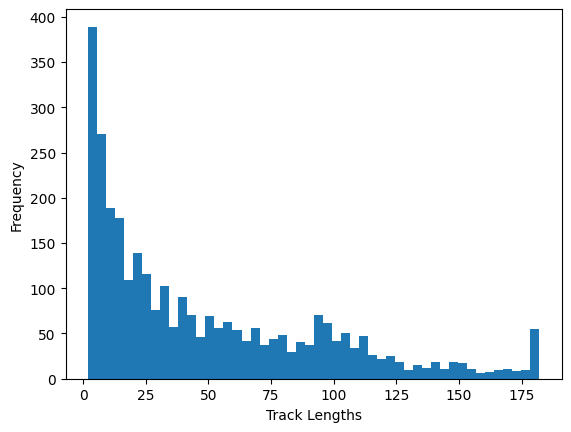

In [48]:
plt.hist(track_lengths, bins=50)
plt.xlabel("Track Lengths")
plt.ylabel("Frequency")
plt.savefig("track-lengths-hist.png")
plt.show()


## Cover Page Visualisation

In [94]:
import open3d as o3d
import torch
import numpy as np

def create_box(center, size, rotation, color=[1, 1, 1]):
    # Create a cuboid (default position and orientation)
    box = o3d.geometry.OrientedBoundingBox(center=center,
                                           R=np.eye(3),
                                           extent=size)
    # Create a rotation matrix
    rotation_matrix = o3d.geometry.get_rotation_matrix_from_xyz((0, 0, rotation))
    # Rotate the box
    box.rotate(rotation_matrix, center=center)
    
    # Convert the bounding box to line set to color it
    box_ls = o3d.geometry.LineSet.create_from_oriented_bounding_box(box)
    box_ls.paint_uniform_color(np.array(color))  # Set the color
    return box_ls

def plot_data(track, points, ground_truth):
    geometries = []
    
    middle_frame_index = len(track) // 2
    max_distance_to_middle = abs(len(track) - middle_frame_index)-4

    # For each track, create a box and add to the list of geometries
    valid_track_indices = [6,9,12,15,18]
    for i, t in enumerate(track):
        if i in valid_track_indices:
            distance_to_middle = abs(i - middle_frame_index)
            color_intensity = 1 - (distance_to_middle / max_distance_to_middle)  # Calculate the color intensity based on the distance to the middle frame
            center, size, rotation = t[:3], t[3:6], t[6]
            box = create_box(center.tolist(), size.tolist(), rotation.item(), color=[0, 0, color_intensity])  # Blue color for tracks, with intensity based on distance to the middle frame
            geometries.append(box)

    # For each point in each frame, create a sphere and add to the list of geometries
    for i, frame_points in enumerate(points):
        if i in valid_track_indices:
            distance_to_middle = abs(i - middle_frame_index)
            color_intensity = distance_to_middle / max_distance_to_middle  # Calculate the color intensity based on the distance to the middle frame
            point_cloud = o3d.geometry.PointCloud()
            # Only taking the first 10 points for each frame
            points_numpy = frame_points.cpu().numpy()
            points_numpy = points_numpy.reshape((-1, 3))  # explicitly reshape to ensure correct format
            point_cloud.points = o3d.utility.Vector3dVector(points_numpy)
            point_cloud.paint_uniform_color([color_intensity, color_intensity, 1])  # Starting from blue and fading to white
            geometries.append(point_cloud)



    # For the ground truth, create a box and add to the list of geometries
    center, size, rotation = ground_truth[:3], ground_truth[3:6], ground_truth[6]
    box = create_box(center.tolist(), size.tolist(), rotation.item(), color=[1, 0, 0])  # Red color for ground truth
    geometries.append(box)

    # Visualize all geometries
    o3d.visualization.draw_geometries(geometries)

In [93]:
tracks, points, gt = track_data[21]
plot_data(tracks, points[:,:,0:3], gt)